# HITO 2 – Análisis de Datos y Formulación del Problema
## Reconocimiento y Clasificación de Tumores Cerebrales – Desarrollo e Integración de Servicios de IA

### 1. Carga de los datos

In [16]:
import zipfile
import os

# Usamos una ruta relativa (sin la barra inicial /)
local_zip = './content/bbdd_tumors.zip' 
random_state=42 # para la reproducibilidad
if os.path.exists(local_zip):
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall('./content')
        zip_ref.close()
        base_dir = '/content/Data'
else:
    print(f"Error: No existe la ruta {os.path.abspath(local_zip)}")

In [17]:
# Estas son los nombres de las carpetas que hay en el zip, y se corresponden con las 4 clases que hay
clases = ['pituitary_tumor', 'meningioma_tumor', 'glioma_tumor', 'normal']

Para realizar el análisis de los datos, vamos a realizar una división train, validación y test con la librería splitfolders con el fin de no cometer fuga de datos al analizar los datos, puesto que no se incluye esta división en la base de datos que hemos descargado. Para ello, dedicaremos el 60% de las imágenes al train, el 20% a la validación, y el 20% restante al test.

In [18]:
!pip install split-folders
import splitfolders

In [ ]:
from pathlib import Path
input = Path(base_dir) 
output = Path(".") / "data"
train_size = 0.6   
val_size = 0.2 
test_size = 0.2 
if not os.path.exists(output):
    splitfolders.ratio(input, output=output, ratio=(train_size, val_size,test_size), seed=random_state)
else:
    print("Directory already exists.")

Directory already exists.


Como podemos ver, tenemos un conjunto de datos muy reducido (tan solo 3096 imágenes), por lo que habrá que usar técnicas de aumentación de datos.

### 2. Análisis del tamaño de las imágenes
El tamaño de todas las imágenes debería ser de 256 x 256, lo cual comprobaremos a continuación

In [20]:
from PIL import Image
import pandas as pd

train_path = "./data/train"
original_sizes = []

for root, dirs, files in os.walk(train_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            with Image.open(os.path.join(root, file)) as img:
                original_sizes.append(img.size) # size es (ancho, alto)

df_sizes = pd.DataFrame(original_sizes, columns=['Ancho', 'Alto'])
print("Tamaños de las imágenes:")
print(df_sizes.value_counts())

Tamaños de las imágenes:
Ancho  Alto
256    256     1855
Name: count, dtype: int64


Como podemos observar, efectivamente todas las imágenes son de 256 x 256, tal y como se indica en la descripción del dataset en Kaggle. Ahora que ya sabemos esto, podemos cargarlas usando la función de ``image_dataset_from_directory`` de Keras para que podamos tratar estas imágenes.

In [ ]:
from tensorflow import keras
batch_size = 32  
image_size = (256,256)
directory = Path(".") / "data"/ "train"  # Directorio donde se ubican los datos
# Genera los datasets de train, validación y test a partir de las imágenes de los directorios
ds_train = keras.utils.image_dataset_from_directory(directory, batch_size = batch_size, image_size = image_size, seed = seed)
directory = Path(".") / "data" / "val"
ds_validation = keras.utils.image_dataset_from_directory(directory, batch_size = batch_size, image_size = image_size, seed = seed)
directory = Path(".") / "data" / "test"
ds_test = keras.utils.image_dataset_from_directory(directory, batch_size = batch_size, image_size = image_size, shuffle = False)

Found 1855 files belonging to 4 classes.
Found 617 files belonging to 4 classes.
Found 624 files belonging to 4 classes.


## 3. Visualización del conjunto de train
Ahora vamos a visualizar algunas de las imágenes del conjunto de entrenamiento

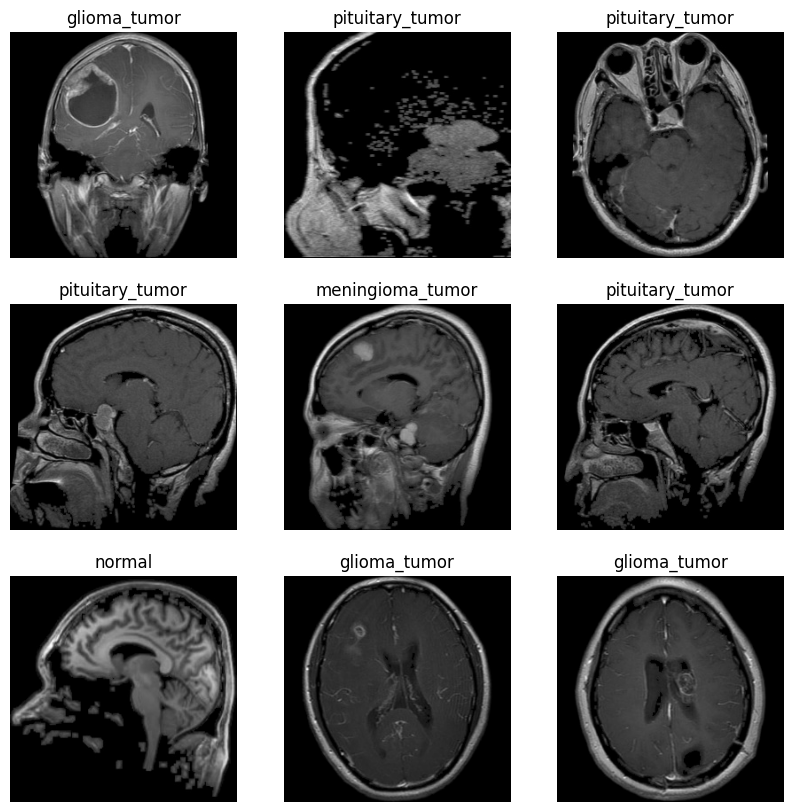

In [22]:
import matplotlib.pyplot as plt
import numpy as np

num = None
figsize = (10, 10)  # tamaño de la imagen
plt.figure(num, figsize)

# Conjunto de datos con 1 solo elemento
tensors = ds_train.take(1)

# Obtenemos las clases del conjunto de entrenamiento
classes = ds_train.class_names
classes = np.array(classes)

for images, labels in tensors:
    for i in range(9):
        # Transformamos el tensor a un array
        image = images[i]
        dtype = np.uint8  # Typecode al que casteamos el array
        image = np.array(image).astype(dtype)

        # Cogemos el label para la imagen que queremos printear
        label = labels[i]
        label = classes[label]

        # Printeamos la imagen
        rows = 3
        columns = 3
        index = i + 1
        option = "off"
        ax = plt.subplot(rows, columns, index)
        plt.imshow(image)
        plt.title(label)
        plt.axis(option)

### 4. Distribución de las clases

Como las clases están desbalanceadas (hay muchas menos instancias para el tumor normal), vamos a asignar pesos a cada clase, con el objetivo de dar mayor peso a las clases que tienen menor frecuencia de aparición. También, normalizaremos estos pesos. En este caso, la clase con menor frecuencia es el tipo de tumor normal, así que será el que más peso tenga.

meningioma_tumor
glioma_tumor
pituitary_tumor
normal
Pesos para cada clase:
------------------------------------
{'meningioma_tumor': 0.19298399393371107, 'glioma_tumor': 0.19548563829951845, 'pituitary_tumor': 0.20862103692043474, 'normal': 0.40290933084633573}
------------------------------------
Frecuencia de aparición de cada clase:


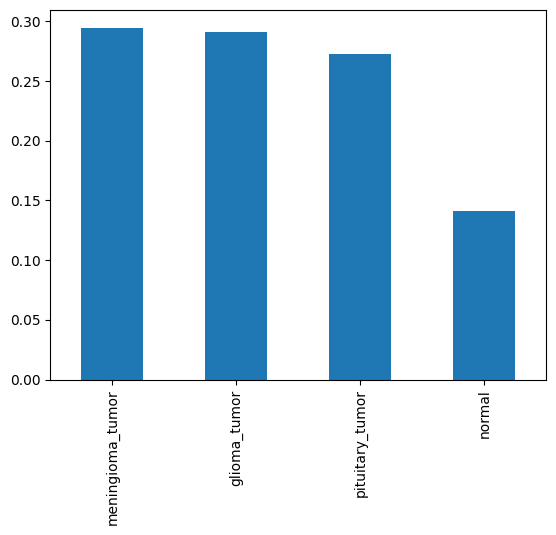

In [23]:
function = lambda file: file.split(os.sep)[2]
iterable = ds_train.file_paths
generator = map(function, iterable)

data = list(generator)  
normalize = True  
sort = True  
kind = "bar"  
frecuencias = pd.Series(data).value_counts(normalize, sort)
#print(frecuencias)
weights = {}
cont = 0
total = 0
for clase,frec in frecuencias.items():
    valor = 1/frec
    weights[clase]= valor
    total += valor
    cont+=1
#print(weights)
#normalizamos pesos
class_weights = {}
cont = 0
for clase,w in weights.items():
    print(clase)
    class_weights[clase] = w/total
    cont+=1
class_indices = {clase: idx for idx, clase in enumerate(frecuencias.keys())}
mapped_class_weights = {class_indices[clase]: peso for clase, peso in class_weights.items()}
print("Pesos para cada clase:")
print("------------------------------------")
print(class_weights)
print("------------------------------------")
print("Frecuencia de aparición de cada clase:")
pd.Series(data).value_counts(normalize, sort).plot(kind = kind);

Como podemos ver, el tumor normal es la variable que más peso tiene, puesto que es la que menos aparece en el dataset, con un peso de 0'4, mientras que la segunda con mayor peso es el tumor de pituitaria con peso de 0'2, seguido del tumor de glioma con peso de 0'195 y por último el de meningioma con peso de 0'192.

## 5. Análisis de intensidad de colores en las radiografías

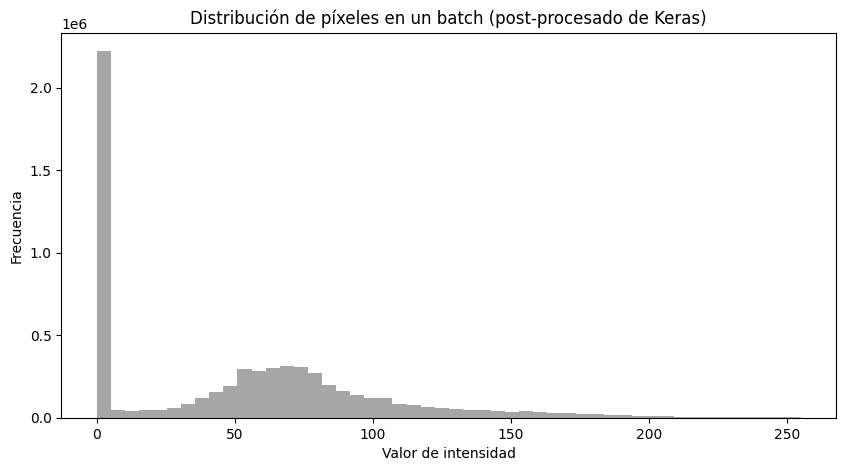

In [24]:
import tensorflow as tf

# Tomamos un batch (32 imágenes)
for images, labels in ds_train.take(1):
    plt.figure(figsize=(10, 5))
    plt.hist(images.numpy().flatten(), bins=50, color='gray', alpha=0.7)
    plt.title("Distribución de píxeles en un batch (post-procesado de Keras)")
    plt.xlabel("Valor de intensidad")
    plt.ylabel("Frecuencia")
    plt.show()

Las imágenes se encuentran en un rango del 0 al 255, que representa toda la escala de grises. A nivel general, vemos que el color predominante en las radiografías es el negro (píxel con valor 0), y la mayoría de la información se encuentra en tonos de color gris oscuro, que es donde va a residir la mayor parte de la información médica. Ahora, vamos a ver si hay alguna diferencia entre clases que nos pueda aportar información relevante:

In [25]:
!pip install opencv-python

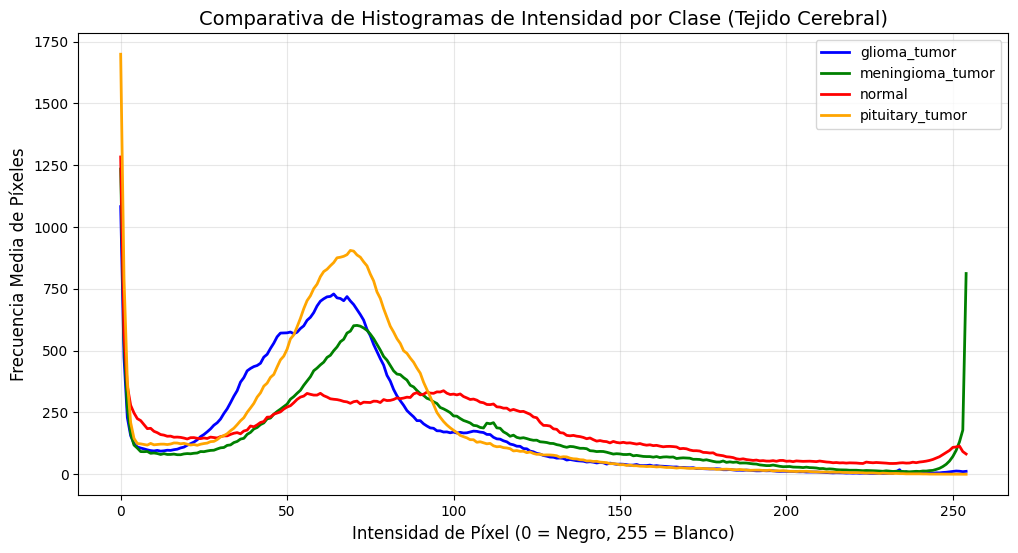

In [26]:
import cv2
# 32 es el número de imágenes que vamos a analizar de cada clase
def plot_histograms_by_class(train_dir, num_samples=32):
    classes = sorted(os.listdir(train_dir))
    colors = ['blue', 'green', 'red', 'orange'] # Un color para el histograma de cada clase
    
    plt.figure(figsize=(12, 6))
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(train_dir, class_name)
        images_names = os.listdir(class_path)[:num_samples]
        
        class_hist = np.zeros((256,))
        
        for img_name in images_names:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # como tenemos las radiografías con escala de grises
            
            if img is not None:
                # Calculamos el histograma de la imagen i
                hist = cv2.calcHist([img], [0], None, [256], [0, 256])
                class_hist += hist.flatten()
        
        # Normalizamos por el número de imágenes para que sean comparables
        class_hist /= len(images_names)
        plt.plot(class_hist[1:], label=class_name, color=colors[i], lw=2)

    plt.title('Comparativa de Histogramas de Intensidad por Clase (Tejido Cerebral)', fontsize=14)
    plt.xlabel('Intensidad de Píxel (0 = Negro, 255 = Blanco)', fontsize=12)
    plt.ylabel('Frecuencia Media de Píxeles', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

train_directory = "./data/train" 
plot_histograms_by_class(train_directory)

Como podemos ver, los tumores de pituitaria tienden a tener mayor presencia de gris oscuro que el resto de tumores. Por otro lado, parece que en el tumor de meningioma hay mucho color blanco, por lo que el brillo podría ser clave a la hora de identificar estos tumores. Además, parece que las radiografías en las que no hay tumor, no hay apenas variación en los tonos de grises, o no es tan marcada como en el resto de radiografías.

## 6. Obtención de la imagen promedio y la desviación

Vamos a ver ahora cuánto parecido tienen las imágenes entre sí para cada clase mediante el cálculo de la imagen. Esto nos permitirá discernir si es necesario realizar aumentación de datos para aportar variabilidad y evitar el sobreajuste.

In [27]:
def visualize_class_fingerprint(class_dir, class_name, img_size=(256, 256)):
    images = []
    filenames = os.listdir(class_dir)[:150] # cogemos 150 imágenes
    
    for img_name in filenames:
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    
    images_array = np.array(images).astype(np.float32)
    
    # Media
    mean_img = np.mean(images_array, axis=0)
    
    # Std
    std_img = np.std(images_array, axis=0)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    im1 = axes[0].imshow(mean_img, cmap='gray')
    axes[0].set_title(f'Imagen Promedio - {class_name}')
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    
    im2 = axes[1].imshow(std_img, cmap='magma')
    axes[1].set_title(f'Desviación Estándar - {class_name}')
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

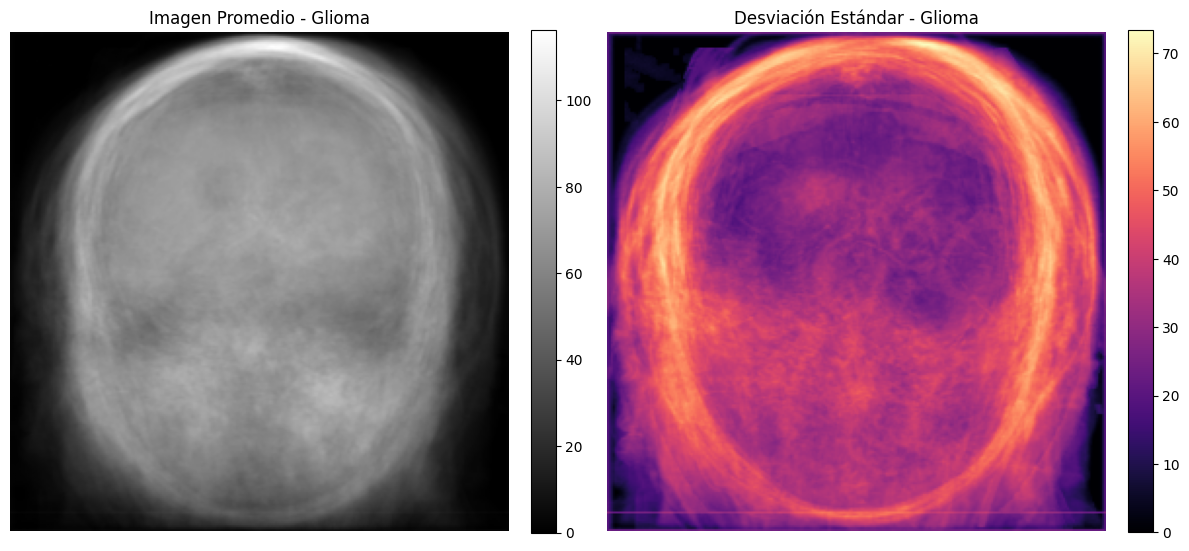

In [28]:
train_dir = "./data/train/glioma_tumor"
visualize_class_fingerprint(train_dir, "Glioma")

Como podemos observar, hay mucha varianza entre las imágenes en los bordes del cráneo, pues cada persona tiene un tamaño de cráneo diferente, pero a grandes rasgos todas las radiografías se han tomado en la misma posición, por lo que una aumentación de datos será necesaria si queremos aportar algo de variabilidad si alguna persona en el futuro se hace una radiografía y la posición no es idéntica a las tomadas en este dataset. 

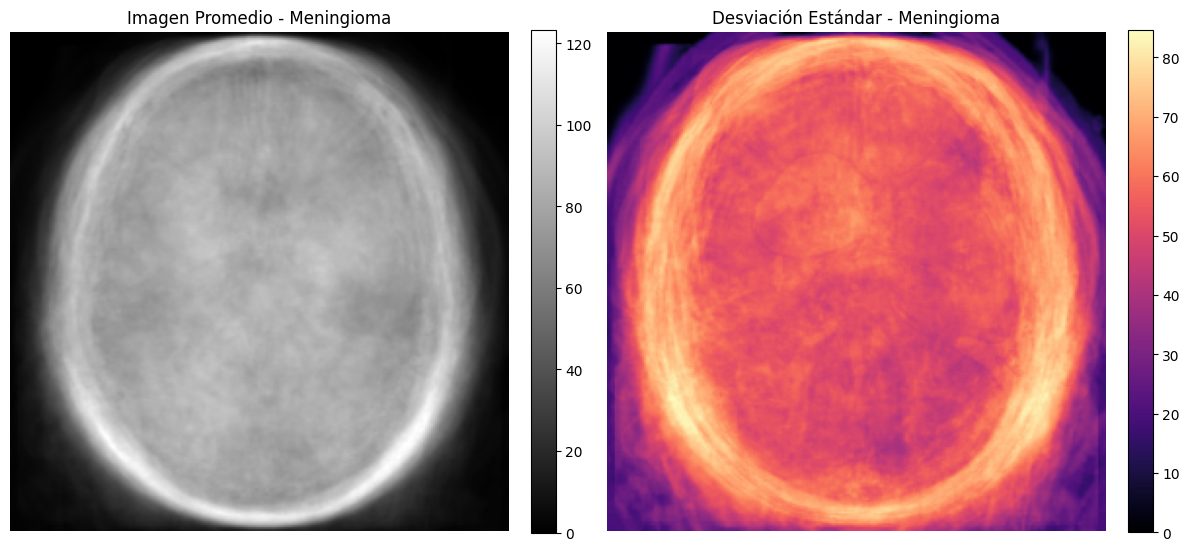

In [29]:
train_dir = "./data/train/meningioma_tumor"
visualize_class_fingerprint(train_dir, "Meningioma")

En este caso, vemos que hay mayor variabilidad con respecto al caso de glioma, tanto en los bordes como en el interior del cerebro (hay colores más rojizos/amarillos), lo que indica que aquí los tamaños de los cráneos eran más diferentes, y posiblemente también el tumor afectase a la forma del cerebro.

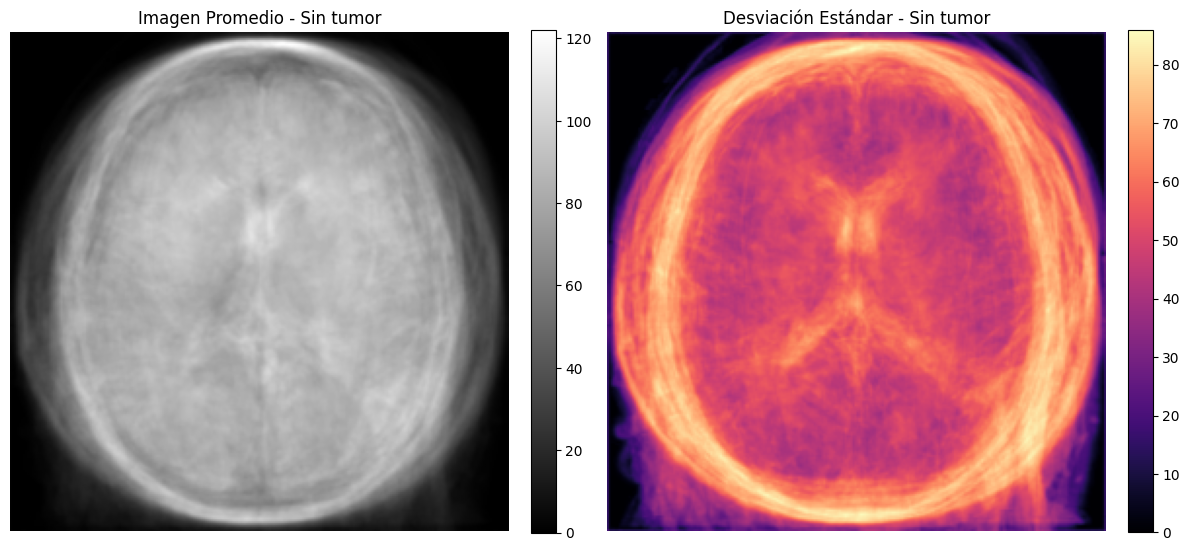

In [30]:
train_dir = "./data/train/normal"
visualize_class_fingerprint(train_dir, "Sin tumor")

Para este caso, hay mucha variabilidad en los bordes, pero llama la atención que justo en la parte central del cerebro hay mucha mayor varianza que en el resto de clases, lo cual puede ser de gran utilidad para discernir esta clase con respecto al resto en visión por computadora.

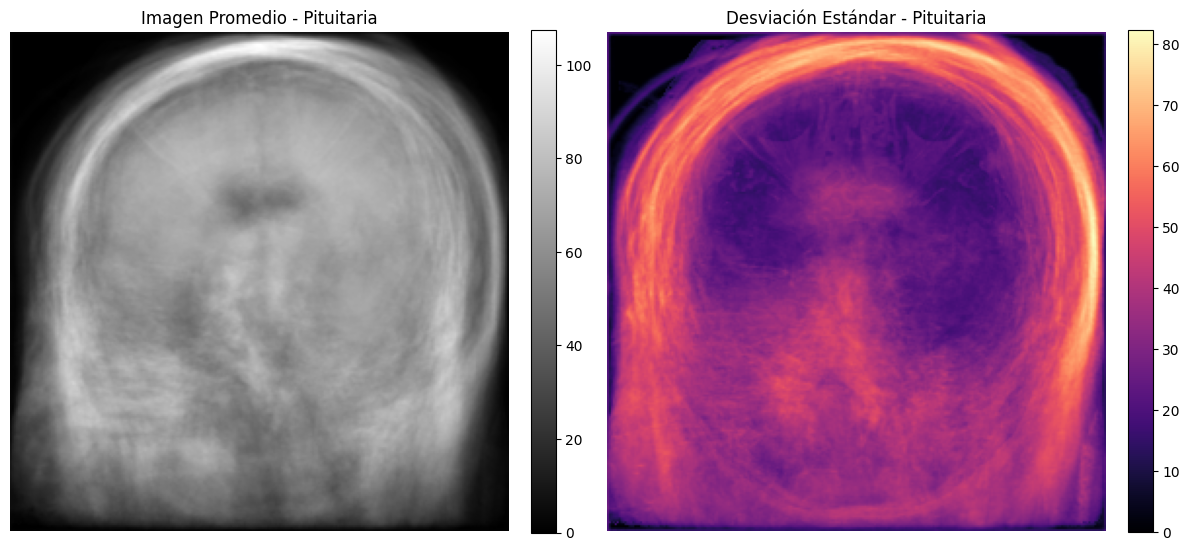

In [31]:
train_dir = "./data/train/pituitary_tumor"
visualize_class_fingerprint(train_dir, "Pituitaria")

Este caso es muy particular, pues vemos que las radiografías no muestran una línea remarcada en la zona inferior del cráneo, por lo que seguramente se hayan realizado utilizando otro escáner menos preciso, o la posición de la cabeza en los pacientes podría haber sido muy diferente, puesto que no se ve una línea fija visible que nos ayude a discernir dónde está el cráneo. Es por tanto, muy importante aplicar algún tipo de rotación a todas las clases, para que no aprenda que el tumor de pituitaria se debe a la rotación de la radiografía.

## 7. Análisis de textura por contraste, homogeneidad y entropía y obtención de bordes

A priori, la textura es diferente entre distintos tipos de tumores, y vamos a apreciar si esto nos va a permitir distinguirlos en las imágenes: por ejemplo, el glioma tiene una textura más rugosa que la del meningioma que es lisa. Así, vamos a emplear las siguientes métricas:
- ``Contraste``: Un valor elevado quiere decir que hay cambios bruscos entre píxeles contiguos, y es indicativo de que se trata de texturas rugosas (propia de los gliomas)
- ``Homogeneidad``: Mide la homogeneidad de la imagen. Si es homogénea, es un posible indicativo de que no hay tumor o el tumor es benigno.
- ``Entropía``: Mide lo compleja que es una imagen. Si la radiografía es muy compleja, es decir, que presenta muchos bordes no regulares, es un posible síntoma de tumores malignos.

In [32]:
!pip install scikit-image

Iniciando análisis de textura para: ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']...


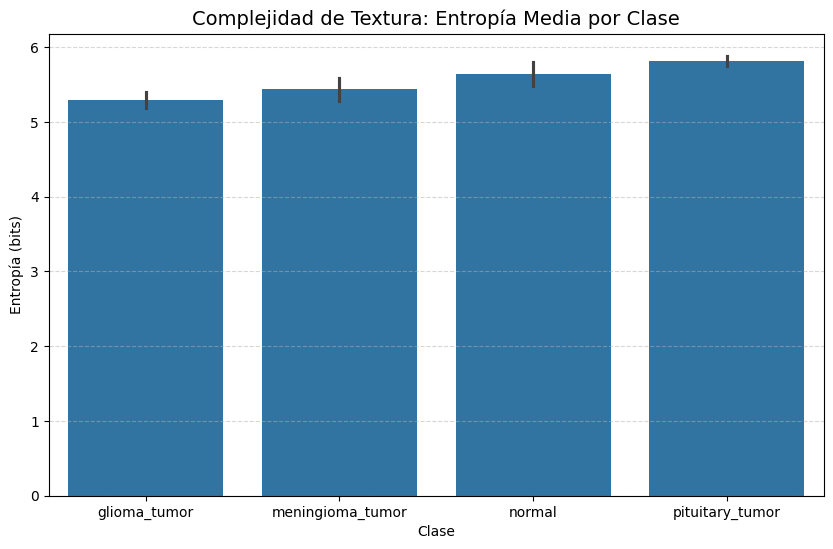

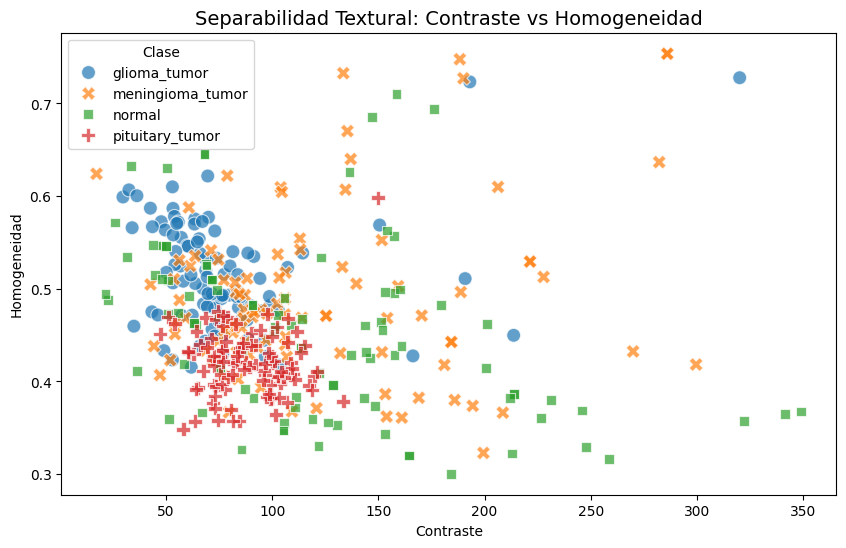

                 Entropía         Contraste          Homogeneidad        
                     mean     std      mean      std         mean     std
Clase                                                                    
glioma_tumor       5.2927  0.5297   78.1136  39.2476       0.5127  0.0586
meningioma_tumor   5.4320  0.8579  120.4510  59.9886       0.4903  0.0901
normal             5.6448  0.8114  120.6397  68.4256       0.4536  0.0915
pituitary_tumor    5.8154  0.3285   87.8854  18.6279       0.4199  0.0352


In [33]:
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy

def run_texture_eda(train_path, samples=100):
    results = []
    # Detectamos las carpetas de las clases
    classes = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])
    
    print(f"Iniciando análisis de textura para: {classes}...")
    
    for cls in classes:
        path = os.path.join(train_path, cls)
        # Tomamos una muestra de imágenes para el análisis estadístico
        files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:samples]
        
        for f in files:
            img = cv2.imread(os.path.join(path, f), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (256, 256))
                
                # Entropía 
                ent = shannon_entropy(img)
                
                # nota: usamos 64 tonos de grises para simplificar el cálculo
                img_64 = (img // 4).astype(np.uint8)
                glcm = graycomatrix(img_64, distances=[5], angles=[0], levels=64, symmetric=True, normed=True)
                
                cont = graycoprops(glcm, 'contrast')[0,0]
                homo = graycoprops(glcm, 'homogeneity')[0,0]
                
                results.append({
                    'Clase': cls,
                    'Entropía': ent,
                    'Contraste': cont,
                    'Homogeneidad': homo
                })

    df = pd.DataFrame(results)
    
    

    plt.figure(figsize=(10, 6))
    order = df.groupby('Clase')['Entropía'].mean().sort_values().index
    sns.barplot(data=df, x='Clase', y='Entropía', order=order)
    plt.title('Complejidad de Textura: Entropía Media por Clase', fontsize=14)
    plt.ylabel('Entropía (bits)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Contraste', y='Homogeneidad', hue='Clase', style='Clase', alpha=0.7, s=100)
    plt.title('Separabilidad Textural: Contraste vs Homogeneidad', fontsize=14)
    plt.show()

    resumen = df.groupby('Clase').agg(['mean', 'std']).round(4)
    return resumen

resumen_texturas = run_texture_eda('./data/train')
print(resumen_texturas)

Vemos que de media, el que tiene mayor entropía es el tumor de pituitaria, y el que menos el glioma. Por otro lado, los que presentan mayor contraste son el meningioma y el normal, y las radiografías más homogéneas son las que no tienen tumores o las que tienen tumor de pituitaria (los benignos). Estas características de las imágenes podrían ayudar a identificar las clases y separarlas. Por otro lado, si nos fijamos en el análisis de las texturas, vemos que la clase del tumor de pituitaria está muy concentrada en un contraste concreto con baja homogeneidad, mientras queel glioma tiene una homogeneidad más elevada, pero de igual forma bajo contraste. Sin embargo, las clases de tumor de meningioma y sin tumor, son difícilmente separables, puesto que no se ven agrupaciones claras, y esto podría ser un problema a la hora de entrenar el modelo.

## 8. Análisis de la separabilidad de las clases mediante PCA y t-SNE

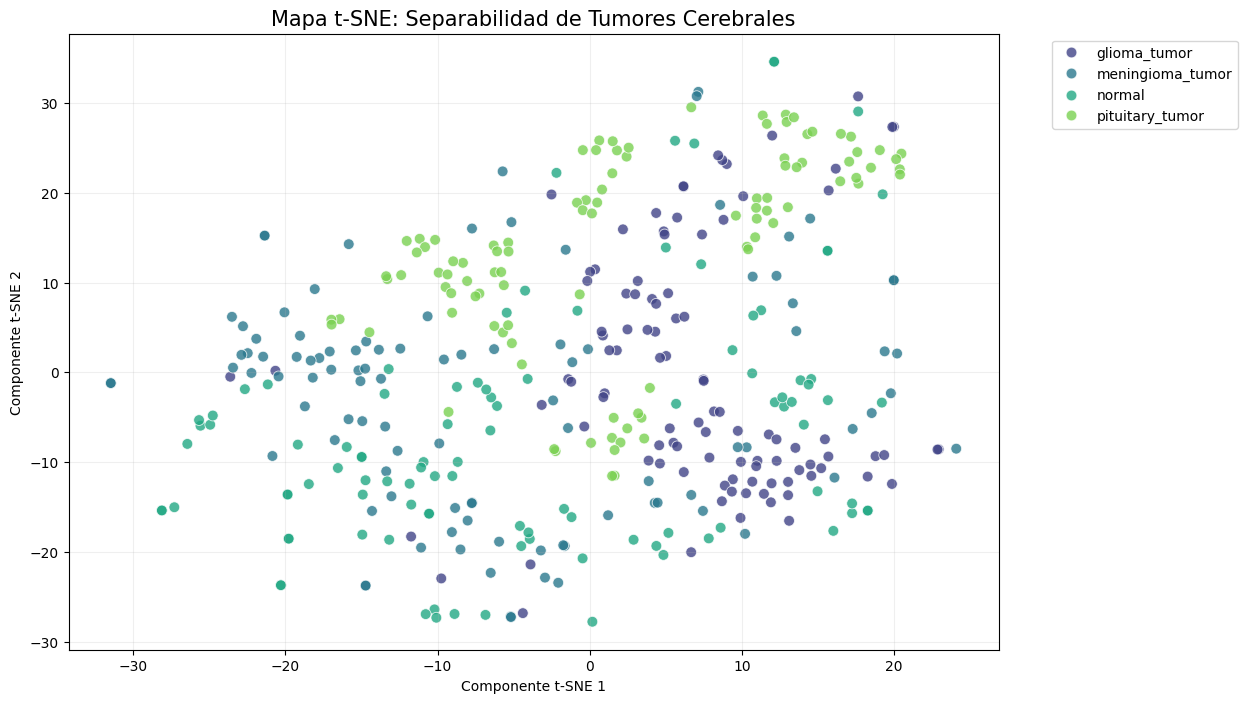

In [37]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def run_tsne_analysis(train_path, n_samples=100):
    features = []
    labels = []
    
    classes = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])
    for cls in classes:
        path = os.path.join(train_path, cls)
        files = os.listdir(path)[:n_samples]
        
        for f in files:
            img = cv2.imread(os.path.join(path, f), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Redimensionamos a 64x64 para reducir la dimensionalidad inicial
                img_resized = cv2.resize(img, (64, 64)).flatten()
                features.append(img_resized)
                labels.append(cls)
    
    X = np.array(features)
    y = np.array(labels)
    
    # PCA con 50 componentes
    pca = PCA(n_components=50, random_state=random_state)
    X_pca = pca.fit_transform(X)
    
    # t-SNE
    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=random_state)
    X_tsne = tsne.fit_transform(X_pca)
    

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', s=60, alpha=0.8)
    plt.title('Mapa t-SNE: Separabilidad de Tumores Cerebrales', fontsize=15)
    plt.xlabel('Componente t-SNE 1')
    plt.ylabel('Componente t-SNE 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.2)
    plt.show()


run_tsne_analysis('./data/train')

Como podemos observar en la gráfica, el tumor de pituitaria sí que parece que se agrupa en la parte superior, pero el resto de clases están más mezcladas (no hay grupos claros), si bien el tumor de glioma parece más enfocado en la zona de la derecha. Por esto, emplear técnicas tradicionales no nos bastará para poder realizar la clasificación de estas imágenes, y será necesario emplear una Red Neuronal Convolucional profunda, ya que el color y la intensidad de la radiografía no son características suficientes para realizar la clasificación correctamente.

## 9. Transformaciones aplicables al conjunto de datos

Como tenemos un conjunto de datos bastante reducido, vamos a aplicar aumentación de datos, y visualizaremos algunas de las imágenes aumentadas. No podremos aplicar algunas técnicas de aumentación como la simetría (puesto que el cerebro es simétrico y un cambio de hemisferio puede significar el cambio en el tipo de tumor cerebral), o el recorte (puesto que podría recortar alguna parte relevante del cerebro), pero sí que podemos aplicar técnicas como el zoom ligero (zoom de hasta 0.2, lo cual no eliminará el tumor de la imagen en ningún caso) o la rotación ligera (rotación de 0.1 en el sentido de las agujas del reloj) para reducir el sesgo de la posición diferente de la cabeza del paciente que hemos detectado antes con el tumor de pituitaria.

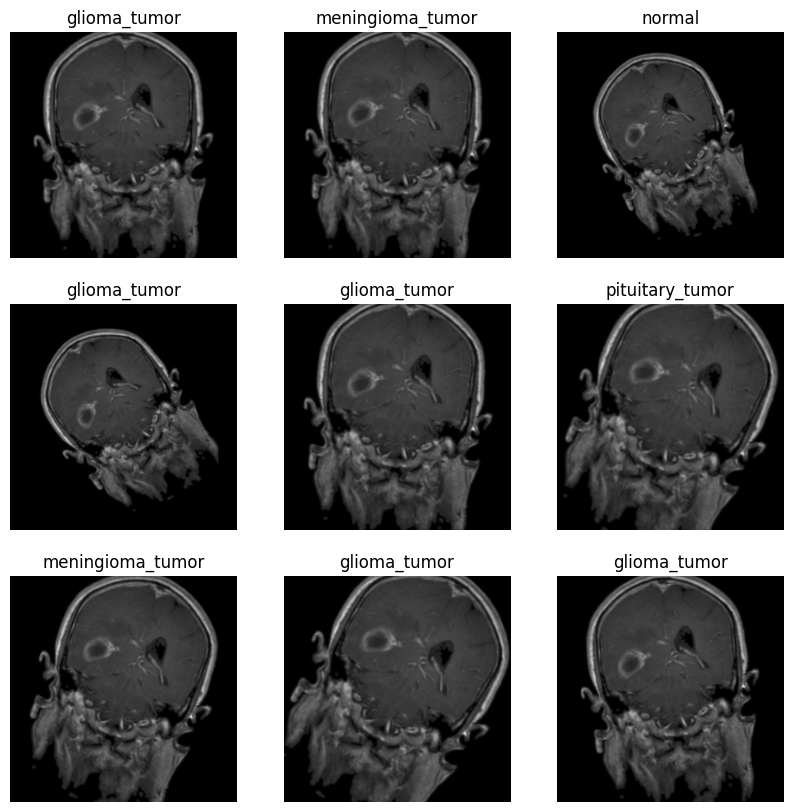

In [35]:
from keras import Sequential
from keras import layers
data_augmentation = Sequential(
    [
        layers.RandomRotation(
        0.1, 
        fill_mode='constant', 
        fill_value=0.0       
        ),
        layers.RandomZoom(
            0.2, 
            fill_mode='constant', # esto hace que las zonas no ampliadas de la imagen se rellenen de color negro
            fill_value=0.0
        )
    ]
)

plt.figure(figsize=(10, 10))
# Conjunto de datos con 1 solo elemento
tensors = ds_train.take(1)
# Obtenemos las clases del conjunto de entrenamiento
classes = ds_train.class_names
classes = np.array(classes)
for images, labels in tensors:
    for i in range(9):
        augmented_images = data_augmentation(images)
        # Transformamos el tensor a un array
        image = augmented_images[i]
        dtype = np.uint8  # Typecode al que casteamos el array
        image = np.array(image).astype(dtype)

        # Cogemos el label para la imagen que queremos printear
        label = labels[i]
        label = classes[label]

        # Printeamos la imagen
        rows = 3
        columns = 3
        index = i + 1
        option = "off"
        ax = plt.subplot(rows, columns, index)
        plt.imshow(image)
        plt.title(label)
        plt.axis(option)



        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

En las imágenes resultantes podemos ver los distintos ejemplos de la rotación del cerebro, y del zoom en el mismo, que en ningún caso afectan a su visualización.

## 10. Conclusiones

En conclusión, hemos extraído las siguientes conclusiones a partir del análisis de las imágenes: 
- Las clases están fuertemente desbalanceadas, y por tanto se aplicará una ponderación basada en pesos con la inversa de la frecuencia de aparición de cada imagen. 
- Todas las imágenes presentan un tamaño fijo de 256 x 256, lo que facilitará el análisis de las mismas, y será fundamental para poder usarlas como entrada en una red neuronal. 
- Por otro lado, el negro es el color predominante en todas las imágenes, y el contraste y brillo que presentan puede ser de utilidad para realizar la clasificación de las imágenes, pero por si sola, la intensidad y la textura no podrá ser empleada con modelos tradicionales como árboles de decisión o regresión puesto que las clases no parecen fácilmente separables, y el empleo de una red neuronal convolucional parece necesario.
- Todos los tumores presentan radiografías similares, a excepción del tumor de pituitaria, en los que el cerebro de media parece que presenta mayor variabilidad en su rotación, por lo que será necesario el empleo de técnicas de aumentación de datos en general para reducir este sesgo que contiene nuestro conjunto de datos. Para ello, se empleará rotación ligera y zoom ligero. 